<a href="https://colab.research.google.com/github/preetamjumech/Cats_Vs_Dogs_CNN_from_scratch/blob/main/Preetam_Saha_Cat_vs_Dog_practice_07_09_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/kaggle"

In [2]:
!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:05<00:00, 243MB/s]
100% 812M/812M [00:05<00:00, 166MB/s]


In [3]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [4]:
!unzip train.zip
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [5]:
#shellscript
import re, shutil 

In [6]:
try:
  os.makedirs("Train")
  os.makedirs("Train/Dog")
  os.makedirs("Train/Cat")
except:
  pass

In [7]:
try:
  os.makedirs("Val")
  os.makedirs("Val/Dog")
  os.makedirs("Val/Cat")
except:
  pass

In [8]:
len(os.listdir('train'))

25000

In [9]:
os.listdir("train")[:10]

['dog.7181.jpg',
 'dog.11742.jpg',
 'cat.8149.jpg',
 'cat.5548.jpg',
 'cat.4913.jpg',
 'dog.10239.jpg',
 'cat.6020.jpg',
 'dog.1023.jpg',
 'dog.6418.jpg',
 'dog.9843.jpg']

In [10]:
import numpy as np

In [11]:
np.random.seed(0)
index = np.array(range(len(os.listdir("train"))))
np.random.shuffle(index) #shuffling will happen in place

In [12]:
train_img_index = np.array(os.listdir("train"))[index[:15000]] #after converting into array, then it is possible to indexing
train_img_index

array(['cat.8707.jpg', 'cat.4259.jpg', 'cat.9285.jpg', ...,
       'cat.10445.jpg', 'cat.11891.jpg', 'cat.9402.jpg'], dtype='<U13')

In [13]:
val_img_index = np.array(os.listdir("train"))[index[15000:]] 
val_img_index

array(['cat.2273.jpg', 'dog.5986.jpg', 'dog.8452.jpg', ...,
       'cat.1036.jpg', 'dog.10757.jpg', 'cat.8477.jpg'], dtype='<U13')

In [14]:
for file in train_img_index:
  if re.findall("dog.+",file):
    shutil.move("train/"+file,"Train/Dog/"+file)
  elif re.findall("cat.+",file):
    shutil.move("train/"+file,"Train/Cat/"+file)
  else:
    continue

In [15]:
for file in val_img_index:
  if re.findall("dog.+",file):
    shutil.move("train/"+file,"Val/Dog/"+file)
  elif re.findall("cat.+",file):
    shutil.move("train/"+file,"Val/Cat/"+file)
  else:
    continue

In [16]:
len(os.listdir("train"))

0

In [17]:
from torchvision.datasets import ImageFolder #imagefolder will go to the folder and read the images 
from torchvision import transforms #transforms automatically converts them into tensors

In [18]:
from torch.utils.data import DataLoader

In [19]:
#data augmentation part
tranf = transforms.Compose([transforms.PILToTensor(),
                            transforms.Resize(size=(256,256)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip()
                            ])

In [20]:
train_loader = DataLoader(ImageFolder("Train",transform = tranf),batch_size=32,shuffle=True)

In [21]:
val_loader = DataLoader(ImageFolder("Val",transform = tranf),batch_size=128,shuffle=False)

In [22]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

In [23]:
class Cat_Vs_Dog(nn.Module):
  def __init__(self):
    super(Cat_Vs_Dog,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1) #in_channels=RGB(3),out_channels=no of filters
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1) #kernel_size=3, padding =1 ,same size
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=16) #for 2
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.bn4 = nn.BatchNorm2d(num_features=64)
    self.drop = nn.Dropout() #dont have parametrs to be learned. so defining only once
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2) #dont have parametrs to be learned. so defining only once
    self.fc1 = nn.Linear(in_features=8*8*256,out_features=512)
    self.fc2 = nn.Linear(in_features=512,out_features=64)
    self.fc3 = nn.Linear(in_features=64,out_features=2)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x) #size = 128

    x = self.bn2(x) #batchnormalization, conv, pooling
    x= F.relu(self.conv2(x))
    x = self.pool(x) #size = 64
 
    x = self.bn3(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x) #size = 32

    x = self.bn4(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x) #size = 16
    x = self.drop(x) 
    
    x = F.relu(self.conv5(x))
    x = self.pool(x) #size = 8

    x = x.view(x.size()[0],-1)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return x

In [24]:
model = Cat_Vs_Dog()

In [32]:
opt = Adam(model.parameters(), lr=0.0001)

In [25]:
import torchsummary

In [26]:
torchsummary.summary(model, input_size=(3,256,256),device="cpu") #in torch channel comes at the beginning

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 32, 128, 128]           4,640
         MaxPool2d-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 64, 64]          18,496
         MaxPool2d-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 128, 32, 32]          73,856
        MaxPool2d-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-14            [-1, 25

In [27]:
from tqdm import tqdm

In [28]:
def train(model, train_loader, opt):
    train_loss = 0.0
    model.train()
    for batch, target in tqdm(train_loader):
        batch = batch.float().to('cuda')
        target = target.to('cuda')

        opt.zero_grad()
        output = model(batch)
        loss = F.cross_entropy(output, target)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    return train_loss

In [29]:
def validate(model, val_loader, opt):
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch, target in tqdm(val_loader):
            batch = batch.float().to('cuda')
            target = target.to('cuda')

            output = model(batch)
            loss = F.cross_entropy(output, target)
            val_loss += loss.item()
    return val_loss

In [30]:
import seaborn as sns

In [33]:
model = model.to('cuda')
hist = {'train_loss':[], 'val_loss':[]}
for epoch in range(1):
    hist['train_loss'].append(train(model, train_loader,opt))
    hist['val_loss'].append(validate(model, val_loader,opt))

100%|██████████| 79/79 [01:06<00:00,  1.18it/s]


In [34]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [35]:
model.conv1.register_forward_hook(get_features('conv_layer_1'))
model.conv2.register_forward_hook(get_features('conv_layer_2'))

In [36]:
for batch,_ in train_loader:
    break

In [37]:
batch.shape

torch.Size([32, 3, 256, 256])

In [38]:
img1 = batch[10]

In [39]:
import matplotlib.pyplot as plt

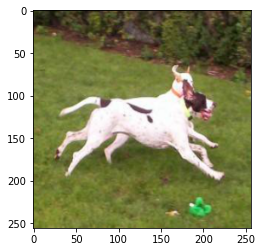

In [40]:
plt.imshow(img1.permute(1,2,0))

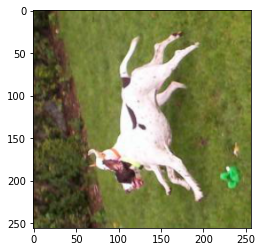

In [41]:
plt.imshow(img1.permute(2,1,0))

In [45]:
out = model(img1.float().reshape(-1,3,256,256).to('cuda'))

In [46]:
out

tensor([[-0.6030,  0.8353]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [47]:
features['conv_layer_1'].size()

torch.Size([1, 16, 256, 256])

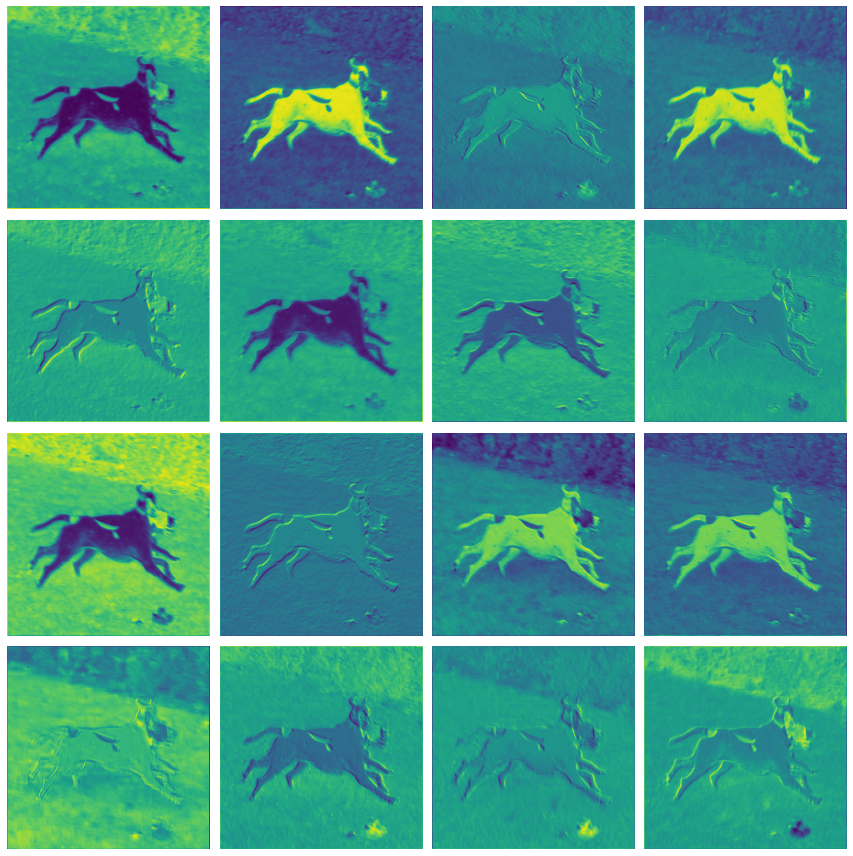

In [48]:
plt.figure(figsize=(12,12))
for idx in range(16):
    plt.subplot(4,4,idx+1)
    plt.axis('off')
    plt.imshow(features['conv_layer_1'][0,idx,:,:].detach().cpu().numpy())
plt.tight_layout()

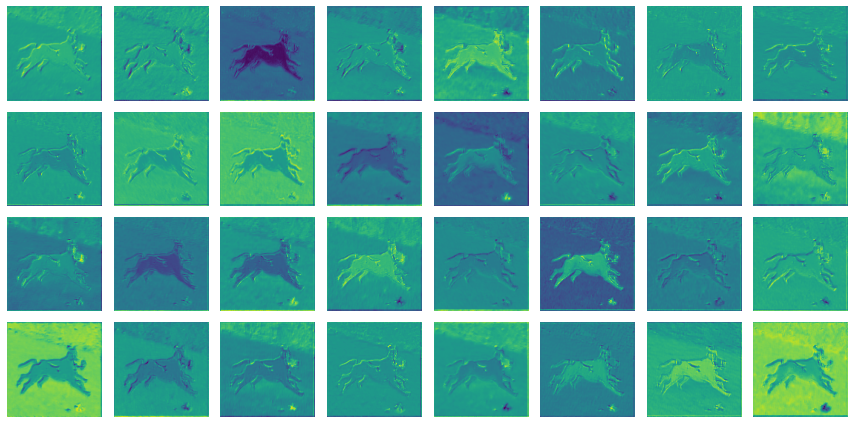

In [50]:
plt.figure(figsize=(12,6))
for idx in range(32):
    plt.subplot(4,8,idx+1)
    plt.axis('off')
    plt.imshow(features['conv_layer_2'][0,idx,:,:].detach().cpu().numpy())
plt.tight_layout()

In [51]:
from torchvision.models import vgg16, VGG16_Weights

In [52]:
vgg_16 = vgg16(weights=VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [53]:
torchsummary.summary(vgg_16, input_size=(3,256,256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [54]:
list(vgg_16.children())[:2]

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [55]:
base_model = nn.Sequential(*list(vgg_16.children())[:2])

for param in base_model.parameters():
    param.requires_grad = False

In [56]:
head_module = nn.Sequential(nn.Flatten(), 
                            nn.Linear(in_features=25088, out_features=128), 
                            nn.ReLU(), 
                            nn.Linear(in_features=128, out_features=32), 
                            nn.ReLU(),
                            nn.Linear(in_features=32, out_features=2))

In [57]:
Cat_Vs_Dog_TL = nn.Sequential(*[base_model,head_module])

In [58]:
torchsummary.summary(Cat_Vs_Dog_TL, input_size=(3,256,256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [59]:
Cat_Vs_Dog_TL = Cat_Vs_Dog_TL.to('cuda')
hist = {'train_loss':[], 'val_loss':[]}
for epoch in range(1):
    hist['train_loss'].append(train(Cat_Vs_Dog_TL, train_loader,opt))
    hist['val_loss'].append(validate(Cat_Vs_Dog_TL, val_loader,opt))

100%|██████████| 79/79 [02:03<00:00,  1.56s/it]


In [60]:
m1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=2, kernel_size=5, padding=0),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, padding=0),
                   nn.ReLU(), 
                   nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=0),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2, stride=2),
                   nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
                   nn.ReLU(), 
                   nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), 
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=2, stride=2), 
                   nn.Flatten())

In [61]:
torchsummary.summary(m1, input_size=(3,64,64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 60, 60]             152
              ReLU-2            [-1, 2, 60, 60]               0
            Conv2d-3            [-1, 4, 56, 56]             204
              ReLU-4            [-1, 4, 56, 56]               0
            Conv2d-5            [-1, 8, 52, 52]             808
              ReLU-6            [-1, 8, 52, 52]               0
         MaxPool2d-7            [-1, 8, 26, 26]               0
            Conv2d-8            [-1, 8, 26, 26]             584
              ReLU-9            [-1, 8, 26, 26]               0
           Conv2d-10           [-1, 16, 26, 26]           1,168
             ReLU-11           [-1, 16, 26, 26]               0
           Conv2d-12           [-1, 32, 26, 26]           4,640
             ReLU-13           [-1, 32, 26, 26]               0
        MaxPool2d-14           [-1, 32,